In [5]:
import numpy as np
import string
import re
from collections import Counter
import re
from utils import load_file, postprocess_answer_option_conditioned, parse_path
from emoji import emojize
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple, Literal
import os
from functools import partial

## Metrics

In [6]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def handle_punc(text):
        exclude = set(string.punctuation + "".join([u"‘", u"’", u"´", u"`"]))
        return ''.join(ch if ch not in exclude else ' ' for ch in text)

    def lower(text):
        return text.lower()

    def replace_underscore(text):
        return text.replace('_', ' ')

    return white_space_fix(remove_articles(handle_punc(lower(replace_underscore(s))))).strip()


def f1_score(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    return normalize_answer(prediction) == normalize_answer(ground_truth)


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    '''
    metric_fn: fns that take two strs only
    pred: str
    gts: list(str)
    '''
    if type(ground_truths) == str:
        ground_truths = [ground_truths]
    ground_truths = [i for i in ground_truths if i.strip() != ""]
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


# def accuracy(preds, labels):
#     match_count = 0
#     for pred, label in zip(preds, labels):
#         target = label[0]
#         if pred == target:
#             match_count += 1

#     return 100 * (match_count / len(preds))

# def accuracy(pred, label):
#     '''
#     akari claimed acc
#     ===
#     pred: str
#     label: str or list(str)
#     '''
#     if type(label) == list:
#         assert len(label) == 1
#         label = label[0]

#     return pred.lower()==label.lower()

def loose_acc(pred, label):
    '''
    pred: str
    label: str
    '''
    # cnt = 0
    def white_space_fix(text):
        return ' '.join(text.split())

    def handle_punc(text):
        exclude = set(string.punctuation + "".join([u"‘", u"’", u"´", u"`"]))
        return ''.join(ch if ch not in exclude else ' ' for ch in text)

    def lower(text):
        return text.lower()

    pred = white_space_fix(handle_punc(lower(pred))).strip()
    label = white_space_fix(handle_punc(lower(label))).strip()
    if pred == label:
        return 1
    if len(pred) < len(label):
        return 0
    # if pred.startswith(label):
    #     cnt += len(label)

    # return cnt / len(pred)
    if len(pred.split())>0 and pred.split()[0] == label:
        return 1

    return 0

def loose_match(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    if ground_truth in prediction:
        return 1
    return 0

## Scores

In [7]:
def compute_confidence(log_probs:List):
    '''
    log_probs: List[float]
    '''
    return np.mean(np.exp(log_probs))

def compute_inv_perplexity(log_probs:List):
    '''
    log_probs: List[float]
    '''
    return np.exp(np.mean(log_probs))

In [8]:
def false_invperplexity(ret_ind):
    return np.sum(ret_ind['id_log_probs']) / max(1, len(ret_ind['token_ids']))

def true_invperplexity(ret_ind):
    return np.sum(ret_ind['id_log_probs']) / max(1, len(ret_ind['id_log_probs']))

def recompute_score_inv_perplexity(ret_res, is_selfrag):
    """pass res['retrieval_res']"""
    
    res = ret_res.copy()
    ret_prefix = ['retrieval_0', 'retrieval_1', 'retrieval_2', 'retrieval_3', 'retrieval_4']
    for prefix in ret_prefix:
        if is_selfrag:
            score = ret_res[prefix]['score'] - false_invperplexity(ret_res[prefix]) + true_invperplexity(ret_res[prefix])
        else:
            assert false_invperplexity(ret_res[prefix]) - ret_res[prefix]['score'] < 1e-5
            score = true_invperplexity(ret_res[prefix])
        res[prefix]['score'] = score
    return res
        

In [9]:
def recompute_score(ret_res, recompute_fn, is_closed, is_selfrag):
    ret_res = ret_res.copy()
    for i in ret_res:
        i['retrieval_res'] = recompute_fn(i['retrieval_res'], is_selfrag)
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result["score"]
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item["score"] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            i["best_one"] = i['retrieval_res'][best_path]
            best_option = i['retrieval_res'][best_path]["pred"]
            token_ids = i['retrieval_res'][best_path]["token_ids"]
            id_log_probs = i['retrieval_res'][best_path]["id_log_probs"]
        else:
            path2score = {key: item["score"] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
            token_ids = i['retrieval_res'][best_path]["token_ids"]
            id_log_probs =i['retrieval_res'][best_path]["id_log_probs"]
            i["best_one"] = i['retrieval_res'][best_path]
        
        i["retrieval"] = best_option
        i["retrieval_token_ids"] = token_ids
        i["retrieval_log_probs"] = id_log_probs
    return ret_res
        

## Indicator

In [6]:
def process_res(res_ls:list):
    
    '''
    dict_keys(['no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs', 'all_doc_retrieval', 'all_doc_retrieval_ids', 'all_doc_retrieval_log_probs', 'retrieval', 'retrieval_token_ids', 'retrieval_log_probs', 'retrieval_res', 'question_id', 'gold', 'question', 'ret_0', 'ret_0_log_probs', 'ret_0_ctx', 'ret_0_ctx_score', 'ret_0_scores', 'ret_1', 'ret_1_log_probs', 'ret_1_ctx', 'ret_1_ctx_score', 'ret_1_scores', 'ret_2', 'ret_2_log_probs', 'ret_2_ctx', 'ret_2_ctx_score', 'ret_2_scores', 'ret_3', 'ret_3_log_probs', 'ret_3_ctx', 'ret_3_ctx_score', 'ret_3_scores', 'ret_4', 'ret_4_log_probs', 'ret_4_ctx', 'ret_4_ctx_score', 'ret_4_scores', 'all_doc_retrieval_ctx', 'all_doc_retrieval_ctx_score', 'all_doc_retrieval_scores', 'no_retrieval_scores'])
    {}_scores dict_keys(['qa', 'qc', 'ca', 'ret_score'])
    '''
    output = []
    prefix = ['ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4', 'all_doc_retrieval', 'no_retrieval', 'retrieval']
    for i, item in enumerate(res_ls):
        max_score = -1
        top_res = None
        for p in prefix:
            if p == "retrieval":
                top_res["ret_name"] = "retrieval"
                output.append(top_res)
                continue
            qa_score = item[p+'_scores']['qa']
            qc_score = item[p+'_scores']['qc']
            ca_score = item[p+'_scores']['ca']
            if p+'_ctx_score' in item:
                assert item[p+'_ctx_score'] == item[p+'_scores']['ret_score']
                ctx_score = float(item[p+'_ctx_score'])
            else:
                ctx_score = float(item[p+'_scores']['ret_score'])
                
            loose_match_ = metric_max_over_ground_truths(loose_match, item[p], item['gold'])
            f1_score_ = metric_max_over_ground_truths(f1_score, item[p], item['gold'])
            em_ = metric_max_over_ground_truths(exact_match_score, item[p], item['gold'])
            loose_acc_ = metric_max_over_ground_truths(loose_acc, item[p], item['gold'])
            dc = {"pred": item[p], "qa_score": qa_score, "qc_score": qc_score, "ca_score": ca_score, "ctx_score": ctx_score, "question_id": item['question_id'], "gold": item['gold'], "question": item['question'], "log_probs": item[p+'_log_probs'], 'confidence': compute_confidence(item[p+'_log_probs']), 'inv_perplexity': compute_inv_perplexity(item[p+'_log_probs']), 'ret_name': p, 'loose_match': loose_match_, 'f1_score': f1_score_, 'em': em_, 'loose_acc': loose_acc_}
            if p in ["ret_0", "ret_1", "ret_2", "ret_3", "ret_4"]:
                if dc['inv_perplexity'] > max_score:
                    max_score = dc['inv_perplexity']
                    top_res = dc.copy()
            output.append(dc)
    
    dc = {"pred": [], "qa_score": [], "qc_score": [], "ca_score": [], "ctx_score": [], "question_id": [], "gold": [], "question": [], "log_probs": [], 'confidence': [], 'inv_perplexity': [], 'ret_name': [], 'loose_match': [], 'f1_score': [], 'em': [], 'loose_acc': []}
    for i, item in enumerate(output):
        for k in dc.keys():
            dc[k].append(item[k])
    return dc

In [17]:
path = 'post_processed\llama2chat-pqa_processed_2mil7.json'
with open(path) as f:
    json_file = json.load(f)
res = process_res(json_file)

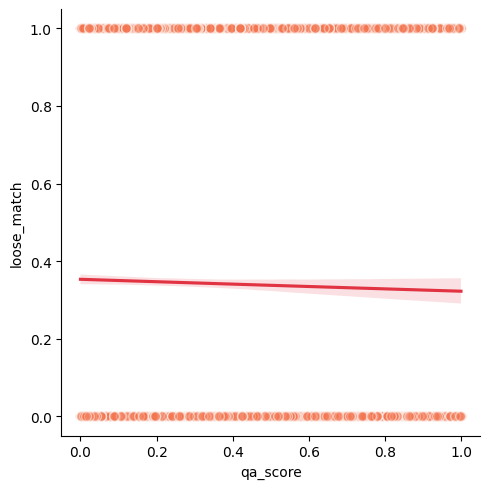

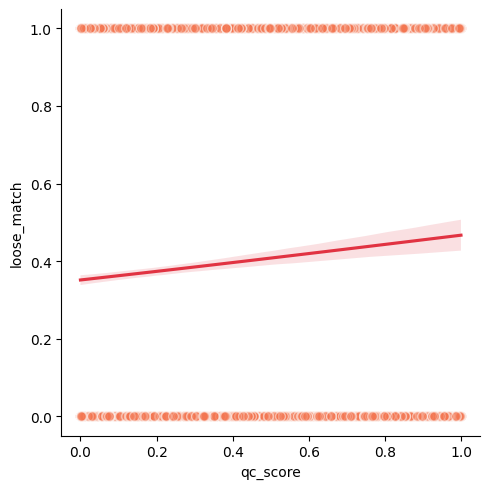

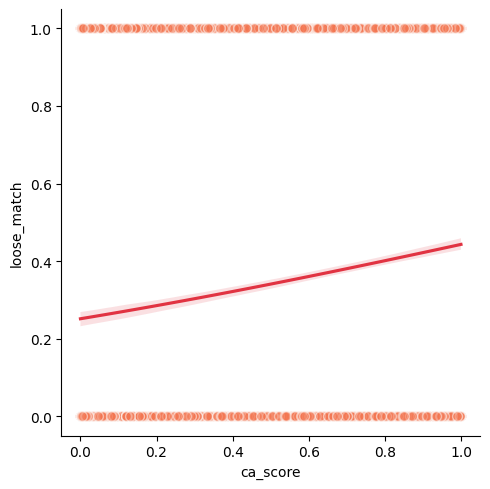

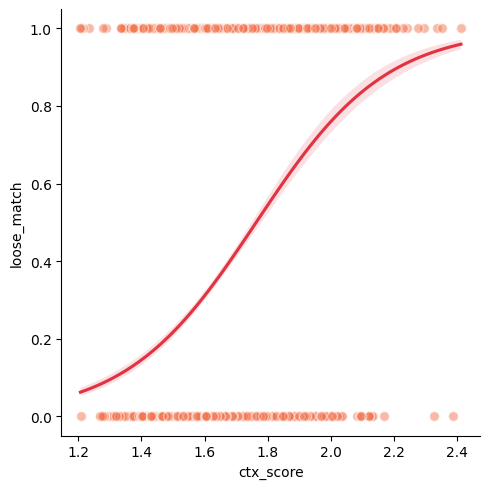

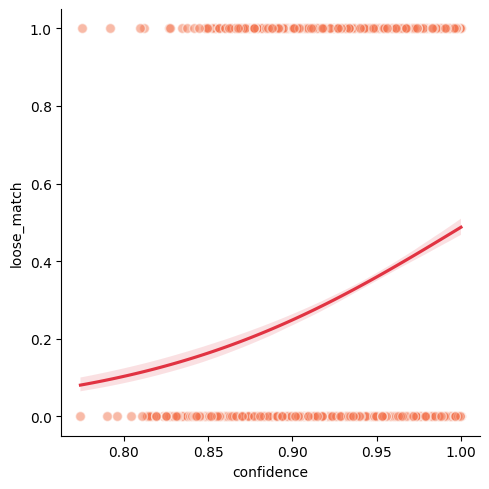

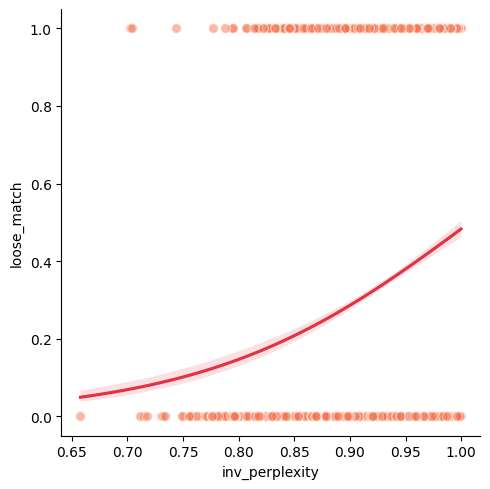

In [7]:



scores = ['qa_score', 'qc_score', 'ca_score', 'ctx_score', 'confidence', 'inv_perplexity']
metric = 'loose_match'

for score in scores:
    df = pd.DataFrame(res)
    df = df[df['ret_name'] != 'retrieval']
    if score == 'ctx_score':
        df = df[(df['ret_name'] != 'no_retrieval') & (df['ret_name'] != 'all_doc_retrieval')]
    elif score in ['qc_score', 'ca_score']:
        df = df[df['ret_name'] != 'no_retrieval']
        
    sns.lmplot(data=df, x=score, y=metric, logistic=True, palette="Set1", scatter_kws={"s": 50, "edgecolor":"w","alpha":.5, 'color': sns.color_palette("rocket")[4]}, line_kws={'color': sns.color_palette("rocket")[3]})

## Res Analysis

In [10]:
def emo_print(s):
    print(emojize(s))
    
    
emo_print(":bear:")

🐻


In [11]:
def select_by_confidence(res, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for i in res:
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = compute_confidence(item['id_log_probs'])
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result['score']
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item['score'] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        else:
            path2score = {key: item['score'] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    print(f"Percentage of right choice: {right_choice/has_hit * 100}%")
    return preds

def select_by_ctx(res, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for i in res:
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = float(item['ctx_score'])
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result['score']
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item['score'] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        else:
            path2score = {key: item['score'] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    print(f"Percentage of right choice: {right_choice/has_hit * 100}%")
    return preds

def select_by_selfeval(res, eval_dc, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for ind, i in enumerate(res):
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                break
            
        answer2score = eval_dc[ind]
        sorted_answers = sorted(
            answer2score.items(), key=lambda x: x[1], reverse=True
        )
        best_option = int(sorted_answers[0][0])-1
        best_option = i['retrieval_res'][f"retrieval_{best_option}"]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    print(f"Percentage of right choice: {right_choice/has_hit * 100}%")
    return preds


def select_by_cfdnctx(res, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for i in res:
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = compute_confidence(item['id_log_probs']) + float(item['ctx_score'])
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result['score']
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item['score'] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        else:
            path2score = {key: item['score'] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    return preds

def select_by_cfdnlogctx(res, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for i in res:
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                # comp_str = f"{compute_confidence(item['id_log_probs'])}, {np.log(float(item['ctx_score']))}"
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = compute_confidence(item['id_log_probs']) + np.log(float(item['ctx_score']))
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result['score']
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item['score'] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        else:
            path2score = {key: item['score'] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        # if acc_ < acc:
        #     print('best', comp_str)
        #     print('chosen',  compute_confidence(i['retrieval_res'][best_path]['id_log_probs']), np.log(float(i['retrieval_res'][best_path]['ctx_score'])))
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    return preds



def select_by_cfdnlogctx_adp(res, is_closed=False, ret_p = None, thres = 0.2):
    print(f"#Adp threshold: {thres}")
    preds = []
    has_hit = 0
    right_choice = 0 
    ret_cnt = 0
    noret_cnt = 0
    for ind, i in enumerate(res):
        if ret_p is not None and ret_p[ind] < thres:
            preds.append(i['no_retrieval'])
            noret_cnt += 1
            continue
        # compute confidence for ret_i
        ret_cnt += 1
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                # comp_str = f"{compute_confidence(item['id_log_probs'])}, {np.log(float(item['ctx_score']))}"
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = compute_confidence(item['id_log_probs']) + np.log(float(item['ctx_score']))
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result['score']
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item['score'] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        else:
            path2score = {key: item['score'] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        # if acc_ < acc:
        #     print('best', comp_str)
        #     print('chosen',  compute_confidence(i['retrieval_res'][best_path]['id_log_probs']), np.log(float(i['retrieval_res'][best_path]['ctx_score'])))
        preds.append(best_option)
    print(f"Ret: {ret_cnt}, NoRet: {noret_cnt}")
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    return preds

def select_by_cfdnsmalllogctx(res, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for i in res:
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                # comp_str = f"{compute_confidence(item['id_log_probs'])}, {np.log(float(item['ctx_score']))}"
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = compute_confidence(item['id_log_probs']) + np.log(float(item['ctx_score'])-1.0)
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result['score']
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item['score'] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        else:
            path2score = {key: item['score'] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        # if acc_ < acc:
        #     print('best', comp_str)
        #     print('chosen',  compute_confidence(i['retrieval_res'][best_path]['id_log_probs']), np.log(float(i['retrieval_res'][best_path]['ctx_score'])))
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    return preds


def select_by_cfdnlogctxnca(res, is_closed=False):
    pass
def select_by_confidence_no_election(res, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for i in res:
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = compute_confidence(item['id_log_probs'])
        
        path2score = {key: item['score'] for key,
                        item in i['retrieval_res'].items()}
        best_path = sorted(path2score.items(),
                            key=lambda x: x[1], reverse=True)[0][0]
        best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    return preds

def select_by_ctx_no_election(res, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for i in res:
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = float(item['ctx_score'])
        
        path2score = {key: item['score'] for key,
                        item in i['retrieval_res'].items()}
        best_path = sorted(path2score.items(),
                            key=lambda x: x[1], reverse=True)[0][0]
        best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    return preds


def select_by_cfdnctx_no_election(res, is_closed=False):
    preds = []
    has_hit = 0
    right_choice = 0 
    for i in res:
        # compute confidence for ret_i
        
        for key, item in i['retrieval_res'].items():
            if is_closed:
                acc = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                acc = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if acc > 0:
                has_hit += 1
                break
            
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = compute_confidence(item['id_log_probs']) + float(item['ctx_score'])
        
        path2score = {key: item['score'] for key,
                        item in i['retrieval_res'].items()}
        best_path = sorted(path2score.items(),
                            key=lambda x: x[1], reverse=True)[0][0]
        best_option = i['retrieval_res'][best_path]["pred"]
        if is_closed:
            acc_ = metric_max_over_ground_truths(loose_acc, best_option, i['gold'])
        else:
            acc_ = metric_max_over_ground_truths(loose_match, best_option, i['gold'])
        if acc_ > 0:
            right_choice += 1
        if acc_ > acc:
            print("something wired...")
        preds.append(best_option)
    print(f"#Right choice rate: {right_choice} out of {has_hit}")
    return preds


def select_plusctx_w_all(res, is_closed=False):
    preds = []
    for i in res:
        # compute confidence for ret_i
        for key, item in i['retrieval_res'].items():
            i['retrieval_res'][key]['score'] = compute_confidence(item['id_log_probs']) + float(item['ctx_score'])
            
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result['score']
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item['score'] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
            best_cfd = compute_confidence(i['retrieval_res'][best_path]['id_log_probs'])
        else:
            path2score = {key: item['score'] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
            best_cfd = compute_confidence(i['retrieval_res'][best_path]['id_log_probs'])
        if compute_confidence(i['all_doc_retrieval_log_probs']) > best_cfd:
            best_option = i['all_doc_retrieval']
        preds.append(best_option)
    return preds

def select_optimal_top(res, is_closed=False):
    preds = []
    cnt = 0
    for i in res:
        # compute confidence for ret_i
        hit = False
        for key, item in i['retrieval_res'].items():
            if is_closed:
                i['retrieval_res'][key]['score'] = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                i['retrieval_res'][key]['score'] = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if i['retrieval_res'][key]['score'] > 0:
                preds.append(item['pred'])
                cnt += 1
                hit = True
                break
        if not hit:
            preds.append(i['no_retrieval'])
    print(f"#retrieval rate: {cnt/len(res)}")
    return preds

def select_optimal_all(res, is_closed=False):
    preds = []
    cnt = 0
    for i in res:
        if is_closed:
            use_all_score = metric_max_over_ground_truths(loose_acc, i['all_doc_retrieval'], i['gold'])
        else:
            use_all_score = metric_max_over_ground_truths(loose_match, i['all_doc_retrieval'], i['gold'])
        if use_all_score > 0:
            preds.append(i['all_doc_retrieval'])
            cnt += 1
            continue
        preds.append(i['no_retrieval'])
    print(f"#retrieval rate: {cnt/len(res)}")
        
    return preds


def select_right_ans(res, is_closed=False):
    preds = []
    cnt = 0
    for i in res:
        # compute confidence for ret_i
        pred = i['retrieval_res']['retrieval_0']['pred']
        for key, item in i['retrieval_res'].items():
            if is_closed:
                i['retrieval_res'][key]['score'] = metric_max_over_ground_truths(loose_acc, item['pred'], i['gold'])
            else:
                
                i['retrieval_res'][key]['score'] = metric_max_over_ground_truths(loose_match, item['pred'], i['gold'])
            if i['retrieval_res'][key]['score'] > 0:
                pred = item['pred']
                cnt += 1
                break
        preds.append(pred)
    print(f"#Optimal right rate: {cnt} out of {len(res)}")
    return preds

In [12]:
class Analyzer:
    def __init__(self, json_path):
        model_name, dataset_name, task, args = parse_path(json_path)
        print('#'*20)
        print(f"#Model: {model_name}")
        print(f"#Dataset: {dataset_name}")
        print(f"#Task: {task}")
        print(f"#Args: {args}")
        # self.metric_evaluation(evaluation_metrics)
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.task = task
        self.args = args
        
        self.dc = self.process_res(json_path)

        self.no_ret_preds = []
        self.use_all_preds = []
        self.select_top_preds = []

    def process_res(self, json_path):
        with open(json_path) as f:
            json_file = json.load(f)
            
            if type(json_file) == list:
                # print(json_file[0].keys())
                # print(json_file[0]['ret_0_scores'].keys())
                res = json_file
            else:
                # print(json_file["results"][0].keys())
                # print(json_file["results"][0]["retrieval_res"].keys())
                res = json_file['results']
                
        if 'ret_0' in res[0]:
            for data in res:
                for i, ret in enumerate(['ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']):
                    assert data["retrieval_res"][f'retrieval_{i}']['pred'] == data[ret]
                    assert data["retrieval_res"][f'retrieval_{i}']['id_log_probs'] == data[ret+'_log_probs']
                    data["retrieval_res"][f'retrieval_{i}']['ctx'] = data[ret+'_ctx']
                    data["retrieval_res"][f'retrieval_{i}']['ctx_score'] = data[ret+'_ctx_score']
                    data["retrieval_res"][f'retrieval_{i}']['scores'] = data[ret+'_scores']
                    
        return res
    

    
    
    def metric_evaluation(self, select_fns = [select_by_confidence], retrieval_methods = ['no_ret', 'use_all', 'select_top']):
        '''
        metric: str
        retrieval_method: str
        threshold: float
        '''
        if 'arc' in self.dataset_name or 'health' in self.dataset_name:
            metric_fn = loose_acc
        else:
            metric_fn = loose_match
        
        golds = [i['gold'] for i in self.dc]
        print('#'*20)
        print(f"#Total number of samples: {len(self.dc)}")
        for method in retrieval_methods:
            print(f"#====== {method} ======#")
            
            if method == 'no_ret':
                preds = [i['no_retrieval'] for i in self.dc]
                metric_res = [metric_max_over_ground_truths(metric_fn, pred, gold) for pred, gold in zip(preds, golds)]
                print(f"#No retrieval {metric_fn.__name__}: {np.mean(metric_res)}")
                self.no_ret_preds = preds
            elif method == 'use_all':
                preds = [i['all_doc_retrieval'] for i in self.dc]
                metric_res = [metric_max_over_ground_truths(metric_fn, pred, gold) for pred, gold in zip(preds, golds)]
                print(f"#Use all {metric_fn.__name__}: {np.mean(metric_res)}")
                self.use_all_preds = preds
            elif method == 'select_top':
                for select_fn in select_fns:
                    try:
                        print(f"#Select top method: {select_fn.__name__}")
                    except:
                        print(f"#Select top method: {select_fn.func.__name__}")
                    preds = select_fn(self.dc, is_closed='arc' in self.dataset_name or 'health' in self.dataset_name)
                    metric_res = [metric_max_over_ground_truths(metric_fn, pred, gold) for pred, gold in zip(preds, golds)]
                    print(f"#Select top {metric_fn.__name__}: {np.mean(metric_res)}")
                    print('# ')
                    self.select_top_preds = preds
        
        return self.no_ret_preds, self.use_all_preds, self.select_top_preds
                

        
                    


In [2]:
# files_dc = {
#     r'eval_res\selfrag-pqa-fullspan.json': r'eval_res\selfragadp-pqa.json',
#     r'eval_res\selfrag-tqa-fullspan.json': r'eval_res\selfragadp-tqa.json',
#     r'eval_res\selfrag-health-fullspan.json': r'eval_res\selfragadp-health.json',
#     r'eval_res\selfrag-arc-fullspan.json': r'eval_res\selfragadp-arc.json',
#     r'eval_res\llama2chat-pqa-fullspan.json': r'eval_res\llama2chat-pqa-selfadp.json',
#     r'eval_res\llama2chat-tqa-fullspan.json': r'eval_res\llama2chat-tqa-selfadp.json',
#     r'eval_res\llama2chat-health-fullspan.json': r'eval_res\llama2chat-health-selfadp.json',
#     r'eval_res\llama2chat-health-fullspan-w_exp.json': r'eval_res\llama2chat-health-selfadp.json',
#     r'eval_res\llama2chat-arc-fullspan.json': r'eval_res\llama2chat-arc-selfadp.json',
#     r'eval_res\llama2chat-arc-fullspan-w_exp.json': r'eval_res\llama2chat-arc-selfadp.json',
#     r'eval_res\llama3Ins-pqa-fullspan.json': r'eval_res\llama3Ins-pqa-selfadp.json',
#     r'eval_res\llama3Ins-tqa-fullspan.json': r'eval_res\llama3Ins-tqa-selfadp.json',
#     r'eval_res\llama3Ins-health-fullspan.json': r'eval_res\llama3Ins-health-selfadp.json',
#     r'eval_res\llama3Ins-health-fullspan-w_exp.json': r'eval_res\llama3Ins-health-selfadp.json',
#     r'eval_res\llama3Ins-arc-fullspan.json': r'eval_res\llama3Ins-arc-selfadp.json',
#     r'eval_res\llama3Ins-arc-fullspan-w_exp.json': r'eval_res\llama3Ins-arc-selfadp.json',
    
# }
files_dc = {
    # r'eval_res\selfrag-pqa-fullspan.json': r'eval_res\selfragadp-pqa.json',
    # r'eval_res\selfrag-tqa-fullspan.json': r'eval_res\selfragadp-tqa.json',
    # r'eval_res\selfrag-health-fullspan.json': r'eval_res\selfragadp-health.json',
    # r'eval_res\selfrag-arc-fullspan.json': r'eval_res\selfragadp-arc.json',
    r'post_processed\llama2chat-pqa_processed_2mil7.json': r'eval_res\llama2chat-pqa-selfadp.json',
    r'post_processed\llama2chat-tqa_processed_2mil7.json': r'eval_res\llama2chat-tqa-selfadp.json',
    r'post_processed\llama2chat-health_processed_2mil7.json': r'eval_res\llama2chat-health-selfadp.json',
    r'post_processed\llama2chat-arc_processed_2mil7.json': r'eval_res\llama2chat-arc-selfadp.json',
    r'post_processed\llama3Ins-pqa_processed_2mil7.json': r'eval_res\llama3Ins-pqa-selfadp.json',
    r'post_processed\llama3Ins-tqa_processed_2mil7.json': r'eval_res\llama3Ins-tqa-selfadp.json',
    r'post_processed\llama3Ins-health_processed_2mil7.json': r'eval_res\llama3Ins-health-selfadp.json',
    r'post_processed\llama3Ins-arc_processed_2mil7.json': r'eval_res\llama3Ins-arc-selfadp.json',
}

# note:
# 1. health不elect好，arc elect好
# 2. log一下ctx—score，除了llama2的pqa都有提升
# 3. 1-log(ctx_score)的效果整体不如log(ctx_score)

In [3]:
for k, v in files_dc.items():
    ret_p_path = v
    with open(ret_p_path, 'r') as f:
        ret_p_file = json.load(f)
        ret_p = ret_p_file["retrieval_p"]
        ret_p_hard = ret_p_file["retrieval_p_hard"]
    path = k
    eval_path = v.replace('selfadp', 'selfeval')
    with open(eval_path, 'r') as f:
        eval_file = json.load(f)
        eval_dc = eval_file["scores"]
    if 'pqa' in path or 'tqa' in path:
        metric="loose_match"
    else:
        metric='loose_acc'
        
    analyzer = Analyzer(path)
    assert len(analyzer.dc) == len(eval_dc) == len(ret_p) == len(ret_p_hard)
    analyzer.metric_evaluation(select_fns=[select_by_confidence,select_by_confidence_no_election, select_by_ctx, select_by_ctx_no_election, partial(select_by_selfeval, eval_dc=eval_dc), select_by_cfdnctx, select_by_cfdnctx_no_election, select_by_cfdnlogctx, partial(select_by_cfdnlogctx_adp, ret_p=ret_p_hard), partial(select_by_cfdnlogctx_adp, ret_p=ret_p, thres = 0.5),  select_plusctx_w_all, select_right_ans, select_optimal_top, select_optimal_all])

NameError: name 'json' is not defined